# Train costum YAMNET


## Create data set


### Record your own data

In [9]:
import pyaudio
import wave
import os
import time

# Constants
CHUNK = 4096
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 16000
DURATION = 10  # Duration of each recording in seconds
OUTPUT_FOLDER = "/home/focus/Bureau/Audio_Node/src/resources/recordings"  # Folder where recordings will be saved

# Create the output folder if it does not exist
if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)

def record_audio(file_path):
    p = pyaudio.PyAudio()
    stream = p.open(format=FORMAT,
                    channels=CHANNELS,
                    rate=RATE,
                    input=True,
                    frames_per_buffer=CHUNK)

    frames = []

    print("Recording...")
    for _ in range(int(RATE / CHUNK * DURATION)):
        data = stream.read(CHUNK, exception_on_overflow=False)
        frames.append(data)

    print("Recording finished.")
    stream.stop_stream()
    stream.close()
    p.terminate()

    with wave.open(file_path, 'wb') as wf:
        wf.setnchannels(CHANNELS)
        wf.setsampwidth(p.get_sample_size(FORMAT))
        wf.setframerate(RATE)
        wf.writeframes(b''.join(frames))

def main():
    index = 1
    while True:
            file_path = os.path.join(OUTPUT_FOLDER, f"{index}.wav")
            record_audio(file_path)
            index += 1
            time.sleep(1)  # Optional delay before starting the next recording
        

if __name__ == "__main__":
    main()


Recording...


KeyboardInterrupt: 

## Download Data from AudioSet

To download data , clone this repo, https://github.com/MorenoLaQuatra/audioset-download.git


    root_path: the path to the directory where the dataset will be downloaded.
    labels: a list of labels to download. If None, all labels will be downloaded.
    n_jobs: the number of parallel downloads. Default is 1.
    download_type: the type of download. It can be one of the following:
        balanced_train: balanced train set.
        unbalanced_train: unbalanced train set. This is the default
        eval: evaluation set.
    copy_and_replicate: if True if a file is associated to multiple labels, it will be copied and replicated for each label. If False, it will be associated to the first label in the list. Default is True.

The methods of the class are:

    download(format='vorbis', quality=5): downloads the dataset.
    The format can be one of the following (supported by yt-dlp --audio-format parameter):
        vorbis: downloads the dataset in Ogg Vorbis format. This is the default.
        wav: downloads the dataset in WAV format.
        mp3: downloads the dataset in MP3 format.
        m4a: downloads the dataset in M4A format.
        flac: downloads the dataset in FLAC format.
        opus: downloads the dataset in Opus format.
        webm: downloads the dataset in WebM format.
        ... and many more.
        The quality can be an integer between 0 and 10. Default is 5.
    read_class_mapping(): reads the class mapping file. It is not used externally.
    download_file(...): downloads a single file. It is not used externally.


## Clean the Data Downloaded

In [1]:
import os
import shutil

# Set your source and destination directories
source_dir = "audioset-download/audioset"
destination_dir = "/home/focus/Bureau/Audio_Node/src/resources/ray_audio/data/test"

# Create destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# Set the size threshold (in bytes)
size_threshold = 150 * 1024  # 150 KB

# Loop through each folder and file in the source directory
for root, dirs, files in os.walk(source_dir):
    for file in files:
        if file.endswith('.wav'):
            file_path = os.path.join(root, file)
            # Check the file size
            if os.path.getsize(file_path) >= size_threshold:
                # Move the file to the destination directory
                shutil.move(file_path, os.path.join(destination_dir, file))
            else:
                # Delete the file if it's smaller than the threshold
                os.remove(file_path)

print("Operation completed.")


Operation completed.


## Orgnize data

In [77]:
import os
import shutil
import random
from pathlib import Path

# Parameters
source_dir = '/home/focus/Bureau/Audio_Node/src/resources/ray_audio/data'  # Original directory with speech, beep, music, etc.
target_dir = '/home/focus/Bureau/Audio_Node/src/resources/ray_audio/fdata'  # Directory where the new structure will be created
split_ratio = 0.8  # Ratio of training data (0.8 for 80% train, 0.2 for 20% test)

# Create target directories if they don't exist
os.makedirs(os.path.join(target_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(target_dir, 'test'), exist_ok=True)

def create_folders(target_path):
    for folder in ['train', 'test']:
        for class_name in os.listdir(source_dir):
            os.makedirs(os.path.join(target_path, folder, class_name), exist_ok=True)

def split_and_move_files(class_name, files, target_path):
    random.shuffle(files)
    split_index = int(len(files) * split_ratio)
    
    train_files = files[:split_index]
    test_files = files[split_index:]
    
    # Move files to train and test folders
    for file in train_files:
        shutil.move(file, os.path.join(target_path, 'train', class_name, os.path.basename(file)))
    for file in test_files:
        shutil.move(file, os.path.join(target_path, 'test', class_name, os.path.basename(file)))

# Create folders
create_folders(target_dir)

# Process each class
for class_name in os.listdir(source_dir):
    class_dir = os.path.join(source_dir, class_name)
    if os.path.isdir(class_dir):
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir) if file.endswith('.wav')]
        split_and_move_files(class_name, files, target_dir)

print("Dataset reorganization complete.")


Dataset reorganization complete.


## Prepare to train


### Import TensorFlow, Model Maker and other libraries

In [2]:
import tensorflow as tf
import tflite_model_maker as mm
from tflite_model_maker import audio_classifier
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import glob
import random

from IPython.display import Audio, Image
from scipy.io import wavfile

print(f"TensorFlow Version: {tf.__version__}")
print(f"Model Maker Version: {mm.__version__}")

TensorFlow Version: 2.8.4
Model Maker Version: 0.4.3


### Training the model

        Make sure your dataset is in this format 
    dataset/
        train/
            speech/
                clip1.wav
                clip2.wav
                ...
            beep/
                clip1.wav
                ...
            music/
                clip1.wav
                ...
            silence/
                clip1.wav
                ...
            robot_moving/
                clip1.wav
                ...
        test/
            speech/
                clip1.wav
                ...
            beep/
                clip1.wav
                ...
            music/
                clip1.wav
                ...
            silence/
                clip1.wav
                ...
            robot_moving/
                clip1.wav
                ...


### Create metdata file

In [74]:
import os
import pandas as pd

base_dir = '/home/focus/Bureau/Audio_Node/src/resources/ray_audio/data' #path to dataset
classes = ['Speech', 'Beep', 'Music', 'Silence', 'Robot moving'] #classes (same name as folders)
data = []

# Loop through each class folder
for class_name in classes:
    class_dir = os.path.join(base_dir, class_name)
    # Loop through each file in the class folder
    for file_name in os.listdir(class_dir):
        if file_name.endswith('.wav'):
            file_path = os.path.join(class_dir, file_name)
            data.append([file_path, class_name])

# Create a DataFrame and save to CSV
df = pd.DataFrame(data, columns=['file_path', 'label'])
df.to_csv(os.path.join(base_dir, 'metadata.csv'), index=False)

print("Metadata file created.")


Metadata file created.


In [75]:


# Path to the metadata CSV file
metadata_file = os.path.join(base_dir, 'metadata.csv')
# Load the metadata CSV file into a DataFrame
df = pd.read_csv(metadata_file)
# Print the number of rows in the DataFrame
print(f"Number of audio clips: {len(df)}")

Number of audio clips: 607


### Load a random audio file

In [45]:
import scipy

In [46]:
def ensure_sample_rate(original_sample_rate, waveform,
                       desired_sample_rate=16000):
  """Resample waveform if required."""
  if original_sample_rate != desired_sample_rate:
    desired_length = int(round(float(len(waveform)) /
                               original_sample_rate * desired_sample_rate))
    waveform = scipy.signal.resample(waveform, desired_length)
  return desired_sample_rate, waveform


Randomly selected audio file: /home/focus/Bureau/Audio_Node/src/resources/ray_audio/data/Beep/EotkYg493i0_7.0-17.0.wav
Label: Beep


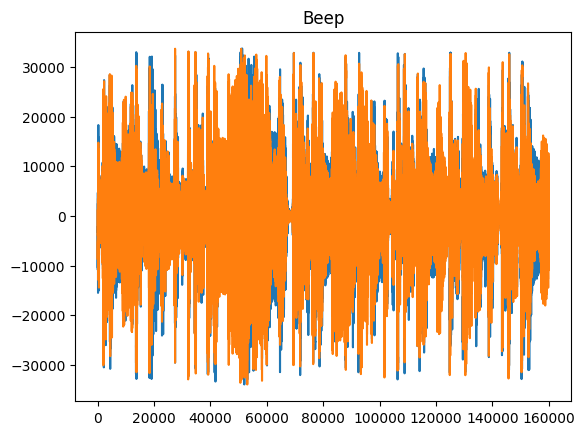

In [73]:
df = pd.read_csv(metadata_file)

# Select a random row from the DataFrame
random_row = df.sample(n=1)

# Get the file path and label from the random row
file_path = random_row['file_path'].values[0]
label = random_row['label'].values[0]
sample_rate, wav_data = wavfile.read(file_path, 'rb')
sample_rate, wav_data = ensure_sample_rate(sample_rate, wav_data)
plttitle = f'{label}'
plt.title(plttitle)
plt.plot(wav_data)



print(f"Randomly selected audio file: {file_path}")
print(f"Label: {label}")


### Training
When using Model Maker for audio, you have to start with a model spec. This is the base model that your new model will extract information to learn about the new classes. 
it also affects the data set

YAMNet

It's input is expected to be at 16kHz and with 1 channel.

You don't need to do any resampling yourself. Model Maker takes care of that for you.

- `frame_length` is to decide how long each traininng sample is. 

- `frame_steps` is to decide how far appart are the training samples. 

The reason to set these values is to work around some limitation in real world dataset.



In [76]:
spec = audio_classifier.YamNetSpec(
    keep_yamnet_and_custom_heads=True,
    frame_step=3 * audio_classifier.YamNetSpec.EXPECTED_WAVEFORM_LENGTH,
    frame_length=6 * audio_classifier.YamNetSpec.EXPECTED_WAVEFORM_LENGTH)

INFO:tensorflow:Checkpoints are stored in /tmp/tmpm692r6yv


INFO:tensorflow:Checkpoints are stored in /tmp/tmpm692r6yv
Exception ignored in: <function Wave_write.__del__ at 0x792bb096c9d0>
Traceback (most recent call last):
  File "/home/focus/anaconda3/envs/training_yamnet/lib/python3.8/wave.py", line 327, in __del__
    self.close()
  File "/home/focus/anaconda3/envs/training_yamnet/lib/python3.8/wave.py", line 445, in close
    self._ensure_header_written(0)
  File "/home/focus/anaconda3/envs/training_yamnet/lib/python3.8/wave.py", line 468, in _ensure_header_written
    self._write_header(datasize)
  File "/home/focus/anaconda3/envs/training_yamnet/lib/python3.8/wave.py", line 472, in _write_header
    self._file.write(b'RIFF')
ValueError: I/O operation on closed file.
Exception ignored in: <function Wave_write.__del__ at 0x792bb096c9d0>
Traceback (most recent call last):
  File "/home/focus/anaconda3/envs/training_yamnet/lib/python3.8/wave.py", line 327, in __del__
    self.close()
  File "/home/focus/anaconda3/envs/training_yamnet/lib/pyt

In [78]:
data_dir = '/home/focus/Bureau/Audio_Node/src/resources/ray_audio/fdata'
train_data = audio_classifier.DataLoader.from_folder(
    spec, os.path.join(data_dir, 'train'), cache=True)
train_data, validation_data = train_data.split(0.8)
test_data = audio_classifier.DataLoader.from_folder(
    spec, os.path.join(data_dir, 'test'), cache=True)

In [83]:
batch_size = 8
epochs = 1

print('Training the model')
model = audio_classifier.create(
    train_data,
    spec,
    validation_data,
    batch_size=batch_size,
    epochs=epochs)

Training the model
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 classification_head (Dense)  (None, 5)                5125      
                                                                 
Total params: 5,125
Trainable params: 5,125
Non-trainable params: 0
_________________________________________________________________
     31/Unknown - 61s 2s/step - loss: 1.5831 - acc: 0.2621

2024-08-14 15:17:20.697207: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Bad format chunk size for WAV: Expected 16 or 18, but got40


     32/Unknown - 61s 2s/step - loss: 1.5690 - acc: 0.2734

InvalidArgumentError: Graph execution error:

Bad format chunk size for WAV: Expected 16 or 18, but got40
	 [[{{node DecodeWav}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_33520]

In [82]:
model.evaluate(test_data)

NameError: name 'model' is not defined

0


4


{'index': 0, 'structVersion': 2, 'name': 'HDA Intel PCH: ALC3232 Analog (hw:0,0)', 'hostApi': 0, 'maxInputChannels': 2, 'maxOutputChannels': 4, 'defaultLowInputLatency': 0.005804988662131519, 'defaultLowOutputLatency': 0.005804988662131519, 'defaultHighInputLatency': 0.034829931972789115, 'defaultHighOutputLatency': 0.034829931972789115, 'defaultSampleRate': 44100.0}
{'index': 1, 'structVersion': 2, 'name': 'HDA Intel HDMI: 0 (hw:1,3)', 'hostApi': 0, 'maxInputChannels': 0, 'maxOutputChannels': 8, 'defaultLowInputLatency': -1.0, 'defaultLowOutputLatency': 0.005804988662131519, 'defaultHighInputLatency': -1.0, 'defaultHighOutputLatency': 0.034829931972789115, 'defaultSampleRate': 44100.0}
{'index': 2, 'structVersion': 2, 'name': 'HDA Intel HDMI: 1 (hw:1,7)', 'hostApi': 0, 'maxInputChannels': 0, 'maxOutputChannels': 8, 'defaultLowInputLatency': -1.0, 'defaultLowOutputLatency': 0.005804988662131519, 'defaultHighInputLatency': -1.0, 'defaultHighOutputLatency': 0.034829931972789115, 'default

ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.side
ALSA lib pcm_route.c:877:(find_matching_chmap) Found no matching channel map
ALSA lib pcm_route.c:877:(find_matching_chmap) Found no matching channel map
ALSA lib pcm_route.c:877:(find_matching_chmap) Found no matching channel map
ALSA lib pcm_route.c:877:(find_matching_chmap) Found no matching channel map
ALSA lib pcm_oss.c:397:(_snd_pcm_oss_open) Cannot open device /dev/dsp
ALSA lib pcm_oss.c:397:(_snd_pcm_oss_open) Cannot open device /dev/dsp
ALSA lib confmisc.c:160:(snd_config_get_card) Invalid field card
ALSA lib pcm_usb_stream.c:482:(_snd_pcm_usb_stream_open) Invalid card 'card'
ALSA lib confmisc.c:160:(snd_config_get_card) Invalid field card
ALSA lib pcm_usb_stream.c:482:(_snd_pcm_usb_stream_open) Invalid card 'card'
